**Project on Lung Cancer Detection Using CNN**

JAYDEEP DARJI

In [ ]:

import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils import to_categorical

import os



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Define paths
train_path_str = '/content/drive/MyDrive/Data/train/'
val_path_str = '/content/drive/MyDrive/Data/valid/'
test_path_str = '/content/drive/MyDrive/Data/test/'

Mounted at /content/drive


In [5]:
test_classes = os.listdir(test_path_str)

In [6]:
input_shape = (224,224,3)
num_classes = 4

trainGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 10,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    dtype = 'float32'
)
valGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)

testGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)


In [7]:
train_data = trainGenertor.flow_from_directory(
    train_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

val_data = valGenertor.flow_from_directory(
    val_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

test_data = testGenertor.flow_from_directory(
    test_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = False
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [8]:
VGG16_model = VGG16(
    include_top = False,
    weights="imagenet",
    input_shape = input_shape
)
for layer in VGG16_model.layers :
  layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [9]:
from keras.src.metrics.confusion_metrics import activations
model = Sequential()
model.add(VGG16_model)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(num_classes,activation = 'softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,125,892 (76.77 MB)

 Trainable params: 5,410,180 (20.64 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [11]:
model.compile(
    optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']
)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint('model.keras',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [12]:
results = model.fit(train_data,validation_data=val_data,epochs=100,verbose = 1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 385s 8s/step - accuracy: 0.3816 - loss: 1.8332 - val_accuracy: 0.4861 - val_loss: 1.8472
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 73s 297ms/step - accuracy: 0.4736 - loss: 1.2044 - val_accuracy: 0.3056 - val_loss: 1.4861
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 298ms/step - accuracy: 0.5053 - loss: 1.1477 - val_accuracy: 0.4861 - val_loss: 1.0090
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 303ms/step - accuracy: 0.5355 - loss: 0.9931 - val_accuracy: 0.4306 - val_loss: 1.0404
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 321ms/step - accuracy: 0.5316 - loss: 1.0103 - val_accuracy: 0.4861 - val_loss: 0.9447
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 293ms/step - accuracy: 0.5781 - loss: 0.9271 - val_accuracy: 0.5417 - val_loss: 1.0354
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 301ms/step - accuracy: 0.6347 - loss: 0.7975 - val_accuracy: 0.6111 - val_loss: 0.9126
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - accuracy: 0.6370 - loss: 0.8231 - val_accuracy: 

In [13]:
loss, acc = model.evaluate(test_data,verbose = 1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 220s 12s/step - accuracy: 0.8608 - loss: 0.3796


In [14]:
import seaborn as sns
predictions_prob = model.predict(test_data)
predictions = np.argmax(predictions_prob , axis = 1)
true_label = test_data.classes
report = classification_report(true_label,predictions)
print(report)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       120
           1       0.86      0.75      0.80        51
           2       1.00      0.94      0.97        54
           3       0.83      0.88      0.85        90

    accuracy                           0.86       315
   macro avg       0.88      0.86      0.87       315
weighted avg       0.86      0.86      0.86       315



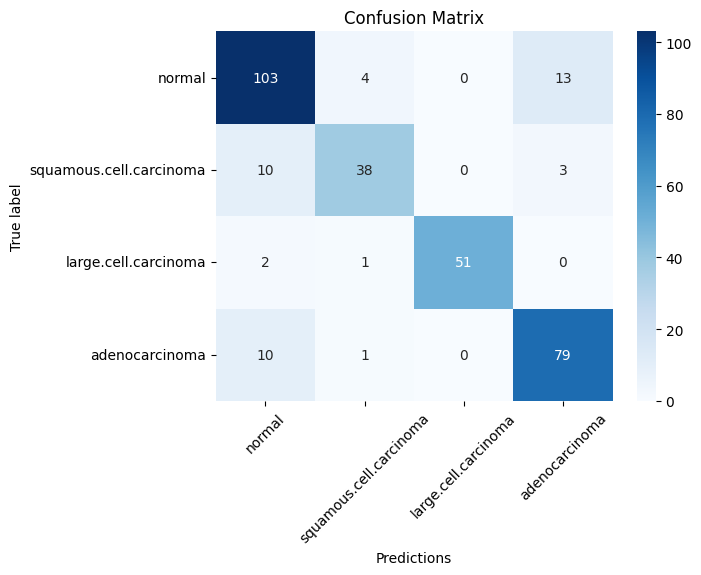

In [15]:
conf_mat = confusion_matrix(true_label,predictions)
sns.heatmap(conf_mat ,fmt='g',annot = True , cmap='Blues' , xticklabels=test_classes , yticklabels = test_classes,)
plt.xlabel('Predictions')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks(rotation = 45)
plt.show()

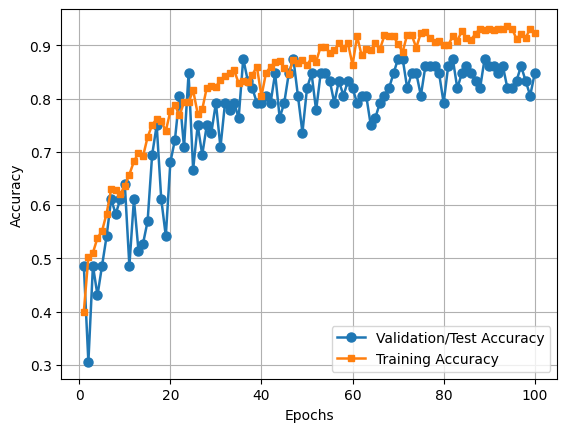

In [16]:
res = results.history
train_acc = res['accuracy']
val_accuracy = res['val_accuracy']
epochs = range(1, len(train_acc) + 1)

line1 = plt.plot(epochs, val_accuracy, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, train_acc, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = 's', markersize = 5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

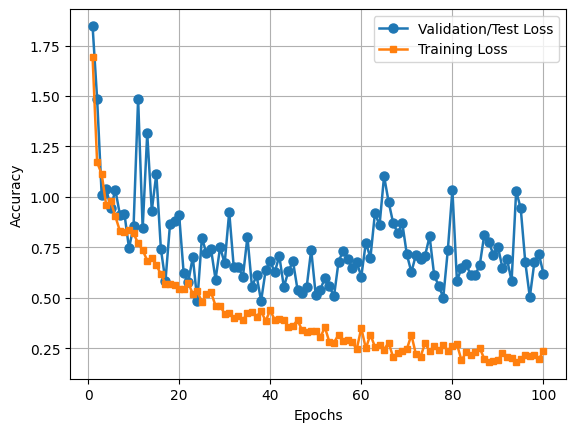

In [17]:
res = results.history
train_loss = res['loss']
val_loss = res['val_loss']
epochs = range(1, len(train_loss) + 1)

line1 = plt.plot(epochs, val_loss, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, train_loss, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = 's', markersize = 5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()